# Library

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# warning 무시
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# Data Load

In [2]:
def data_load(dir, label):
  data = glob.glob(f'{dir}/*.png')

  plt.figure(figsize=(8, 8))
  for i, images in enumerate(data[:9]):
      ax = plt.subplot(3, 3, i + 1)
      mask_img = cv2.imread(images)
      mask_img =  cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
      plt.imshow(mask_img)
      plt.title(f'{label} {mask_img.shape}')
      plt.axis("off")

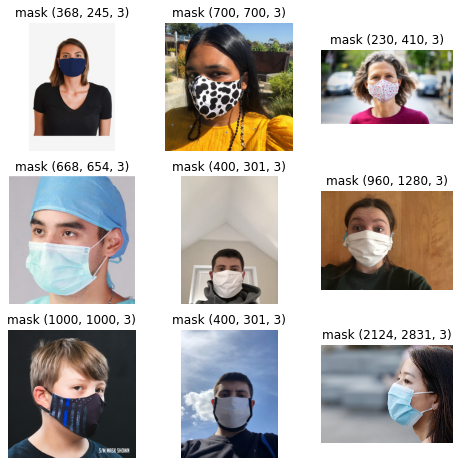

In [3]:
# 마스크 착용 이미지 
mask_dir = '/content/drive/My Drive/mask/with_mask'
data_load(dir=mask_dir, label='mask')

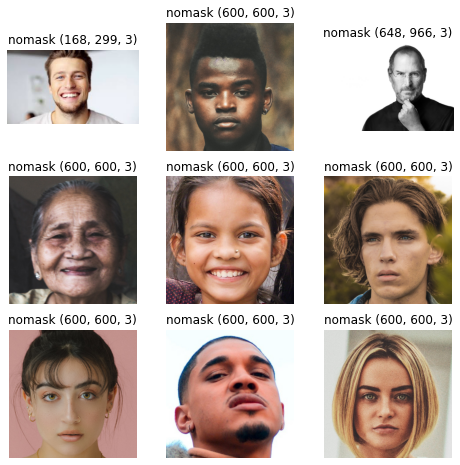

In [4]:
# 마스크 미착용 이미지
nomask_dir = '/content/drive/My Drive/mask/without_mask'
data_load(dir=nomask_dir, label='nomask')

# Tensorflow

## Split train&valid set

학습:검증 비율 -> 8:2 로 나눕니다.

In [5]:
data_split = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

이미지의 사이즈는 16 by 16으로 설정

In [6]:
width = 256
height = 256

training 이미지 불러오기

In [7]:
trainData = data_split.flow_from_directory(directory = '/content/drive/My Drive/mask/',
                                           target_size = (height, width),
                                           class_mode = 'binary',
                                           batch_size = 64,
                                           subset='training')

Found 352 images belonging to 2 classes.


In [8]:
trainData.num_classes

2

In [9]:
trainData.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
trainData.class_indices

{'with_mask': 0, 'without_mask': 1}

validation 이미지 불러오기

In [11]:
valData =data_split.flow_from_directory(directory = '/content/drive/My Drive/mask/',
                                         target_size =(height, width),
                                         class_mode = 'binary',
                                         batch_size = 64,
                                         subset='validation')

Found 88 images belonging to 2 classes.


In [12]:
valData.num_classes

2

In [13]:
valData.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [14]:
valData.class_indices

{'with_mask': 0, 'without_mask': 1}

## Modeling Using deeplearning

In [84]:
def modeling():
  model = Sequential()

  # 입력층
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu', input_shape=(width, height, 3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=1))


  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                  activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=1))
  model.add(Dropout(0.2))

  # Fully-connected layer
  model.add(Flatten())
  model.add(Dense(units=64, activation="relu"))
  model.add(Dense(units=32, activation="relu"))

  # 출력층=> binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

In [85]:
model = modeling()

레이어 시각화

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 252, 16)      2320      
                                                                 
 conv2d_14 (Conv2D)          (None, 250, 250, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 249, 249, 16)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 247, 247, 16)      2320      
                                                                 
 conv2d_16 (Conv2D)          (None, 245, 245, 16)      2320      
                                                      

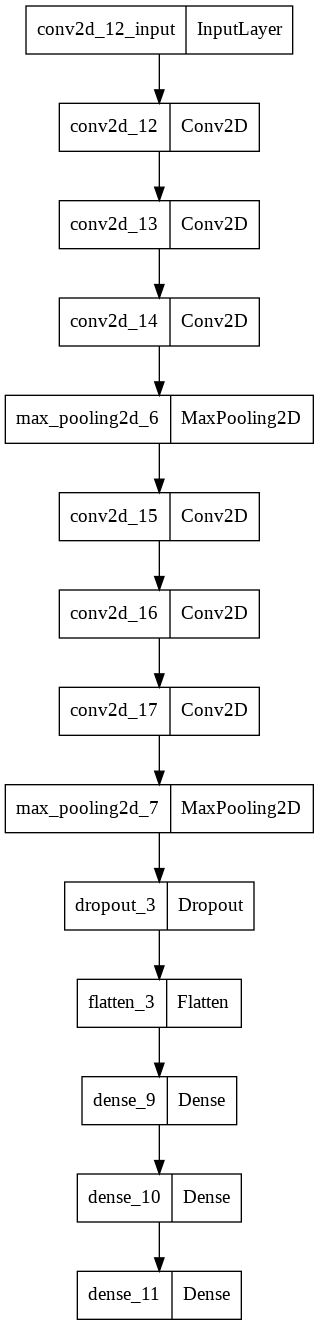

In [87]:
plot_model(model)

컴파일

In [88]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="accuracy"
)

## Train

In [89]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
early_stop

In [90]:
history = model.fit(trainData, epochs=1000, 
                    callbacks=early_stop, validation_data=valData)

Epoch 1/1000
6/6 [==============================] - 131s 21s/step - loss: 0.9340 - accuracy: 0.4943 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/1000
6/6 [==============================] - 135s 23s/step - loss: 0.7304 - accuracy: 0.4574 - val_loss: 0.6810 - val_accuracy: 0.7273
Epoch 3/1000
6/6 [==============================] - 120s 22s/step - loss: 0.6670 - accuracy: 0.5511 - val_loss: 0.6565 - val_accuracy: 0.6250
Epoch 4/1000
6/6 [==============================] - 125s 21s/step - loss: 0.5904 - accuracy: 0.7358 - val_loss: 0.5960 - val_accuracy: 0.6705
Epoch 5/1000
6/6 [==============================] - 127s 21s/step - loss: 0.4474 - accuracy: 0.8097 - val_loss: 0.5324 - val_accuracy: 0.7841
Epoch 6/1000
6/6 [==============================] - 128s 21s/step - loss: 0.3628 - accuracy: 0.8239 - val_loss: 0.3718 - val_accuracy: 0.8750
Epoch 7/1000
6/6 [==============================] - 129s 21s/step - loss: 0.2555 - accuracy: 0.9034 - val_loss: 0.3816 - val_accuracy: 0.8409
Epoch 

In [91]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,0.934001,0.494318,0.694283,0.500000
1,0.730426,0.457386,0.680976,0.727273
2,0.666961,0.551136,0.656544,0.625000
3,0.590432,0.735795,0.595980,0.670455
4,0.447450,0.809659,0.532362,0.784091
5,0.362781,0.823864,0.371836,0.875000
6,0.255456,0.903409,0.381602,0.840909
7,0.172096,0.926136,0.421957,0.829545
8,0.121807,0.954545,0.518540,0.875000
9,0.067345,0.980114,0.528935,0.875000


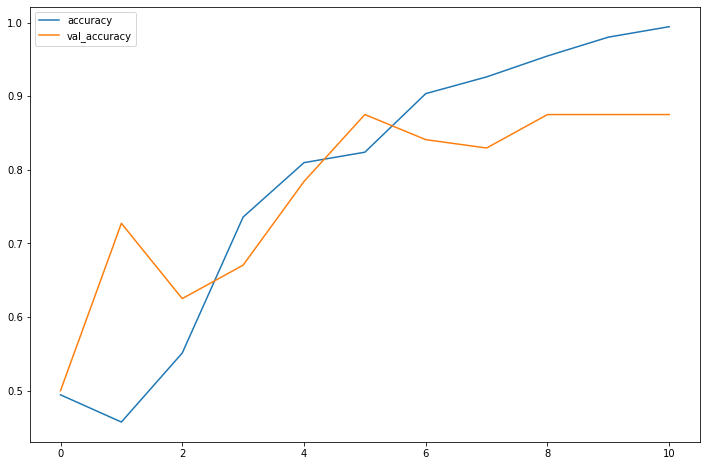

In [92]:
df_hist[['accuracy', 'val_accuracy']].plot(figsize=(12,8))

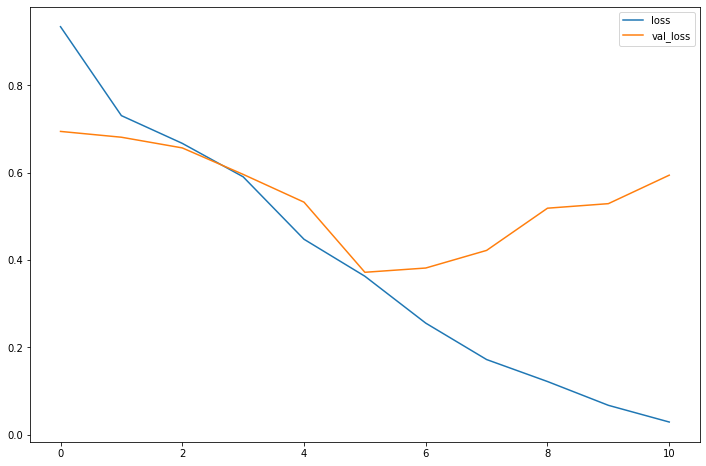

In [93]:
df_hist[['loss', 'val_loss']].plot(figsize=(12,8))

In [94]:
def test_load(dir, label):
  data = glob.glob(f'{dir}/*.jpg')

  plt.figure(figsize=(8, 8))
  for i, images in enumerate(data[:9]):
      ax = plt.subplot(3, 3, i + 1)
      img = cv2.imread(images)
      img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.title(f'{label} {img.shape}')
      plt.axis("off")

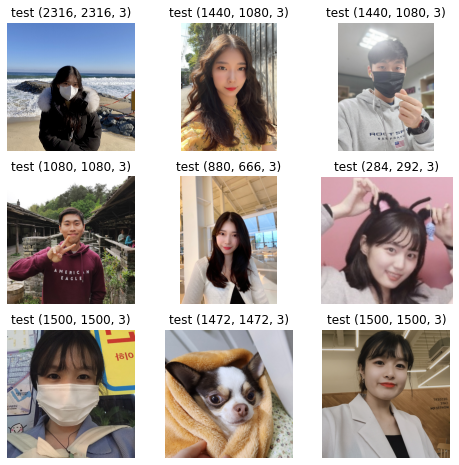

In [95]:
testdata_path = '/content/drive/My Drive/testdata_mask'
test_load(testdata_path, 'test')

In [96]:
def predict(path, width, height):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(height,width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    
    y_pred = model.predict(np.array([img]))

    if y_pred[0][0] > 0.5 :
        return f'Without Mask : {y_pred[0][0]*100 : .2f}%'
    else:
        return f'With Mask : {(1-y_pred[0][0])*100 : .2f}%'

1/1 [==============================] - 0s 112ms/step


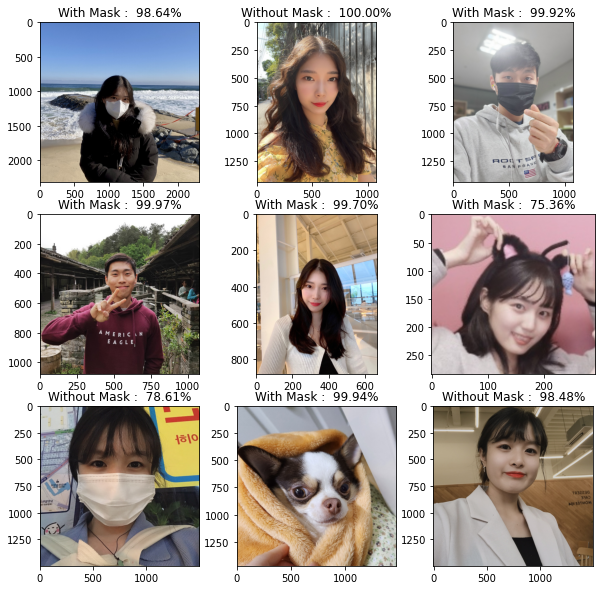

In [97]:
test_list = glob.glob(f'{testdata_path}/*.jpg')

fig, axes = plt.subplots(3,3, figsize=(10,10))
for i, img in enumerate(test_list):
  image = cv2.imread(img)
  image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  axes[int(i//3), int(i%3)].imshow(image)
  
  title = predict(img, width=width, height=height)
  axes[int(i//3), int(i%3)].set_title(f'{title}')

아니 왜 구분 못해 ........... ?